<a href="https://colab.research.google.com/github/lverwimp/RNN_language_modeling/blob/master/rnn_lms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Language Modeling with Recurrent Neural Networks

In this notebook, we will see how you can train a recurrent neural network language model.

We will start by importing TensorFlow, which is Google's open-source library for machine learning. Next, we will explain how to do data processing for language modeling and show you how we can train and test models.

## Importing TensorFlow and other requirements

We start by importing TensorFlow and checking if we are running on GPU:

In [0]:
import tensorflow as tf

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')

If the code above raised an error, you should make sure that you are using a GPU in the following way: select 'Runtime' in the top bar, then 'Change runtime type' and choose 'GPU' as hardware accelerator. Training neural networks is much faster on a GPU (graphics processing unit) than on a CPU.

Next, we do the other imports we need. The following code will allow you to upload files: you have to upload batchGenerator.py, rnn_lm.py and run_lm.py.

In [2]:
import numpy as np
import urllib, collections, os
from __future__ import print_function

# upload batchGenerator.py, rnn_lm.py, run_lm.py (all at once)
from google.colab import files
uploaded = files.upload()

Saving batchGenerator.py to batchGenerator.py
Saving rnn_lm.py to rnn_lm.py
Saving run_lm.py to run_lm.py


If the files are uploaded correctly, the following imports should succeed:

In [0]:
import rnn_lm, batchGenerator, run_lm

If the imports did not succeed, you should restart the runtime ('Runtime' in the top bar and then 'Restart runtime') and/or delete the files in the overview to the left (tab 'Files').

If you imported all libraries, you can now start the following section on data processing.

## Data processing

We will train our language models on **Penn TreeBank**, which is a publicly available benchmark dataset. A benchmark dataset can be used to easily compare models, since everyone has access to the same data. Many published papers use Penn TreeBank as dataset.

It consists of among others newspaper articles, transcribed telephone conversations and manuals. The training set contains ca. 900.000 words, the validation set ca. 70.000 words and the test set ca. 80k words. This is a very small dataset (nowadays language models can be trained on billions of words), but it is large enough for our purposes.

We now download the training, validation and test data:

In [0]:
train_url = 'http://homes.esat.kuleuven.be/~spchlab/H02A6/lab/session6/data/train.txt'
valid_url = 'http://homes.esat.kuleuven.be/~spchlab/H02A6/lab/session6/data/valid.txt'
test_url = 'http://homes.esat.kuleuven.be/~spchlab/H02A6/lab/session6/data/test.txt'
train_file = urllib.urlopen(train_url).read()
valid_file = urllib.urlopen(valid_url).read()
test_file = urllib.urlopen(test_url).read()

The data looks like this:

In [0]:
print('{0}...'.format(valid_file[:500]))

 consumers may want to move their telephones a little closer to the tv set 
 <unk> <unk> watching abc 's monday night football can now vote during <unk> for the greatest play in N years from among four or five <unk> <unk> 
 two weeks ago viewers of several nbc <unk> consumer segments started calling a N number for advice on various <unk> issues 
 and the new syndicated reality show hard copy records viewers ' opinions for possible airing on the next day 's show 
 interactive telephone technology...


The data has been **normalized**: all words not in the vocabulary are mapped to an unknown words class (<unk\>), all numbers are mapped to the 'N' class, each line contains a single sentence, punctuation has been removed, and so on. 

The purpose of normalization is among others to get rid of all information that is not necessary (such as punctuation), to solve redundancies (for example the same word can occur with different spellings, e.g. 'normalisation' or 'normalization', and we want to get rid of such variants) and to make sure the language model will be able to generalize better. An example of the latter case is the mapping of all numbers to 'N':  in the example above, 'in N years', 'N' can correspond to any number. Assume that in our training data, we see 'in 20 years' and 'in 11 years', and in our test data, we see 'in 5 years'. If '20', '11' and '5' are not mapped to 'N', we have never seen 'in 5 years' before, and the probability estimate will be worse.
  
We will now read the data, add end-of-sentence symbols (since we want to be able to predict the end of a sentence too), and count the frequency of every word in the training data:

In [0]:
# convert the string to a list and replace newlines with the end-of-sentence symbol <eos>
# ignore empty elements ''
train_text = [w for w in train_file.replace('\n',' <eos>').split(' ') if w != '']
valid_text = [w for w in valid_file.replace('\n',' <eos>').split(' ') if w != '']
test_text = [w for w in test_file.replace('\n',' <eos>').split(' ') if w != '']

# count the frequencies of the words in the training data
counter = collections.Counter(train_text)

# sort according to decreasing frequency
count_pairs = sorted(counter.items(), key=lambda x: (-x[1], x[0]))

We can take a look at the frequencies of the words in the training set, and compare them with the frequencies of the words in the validation set. The top 20 words is quite similar:

In [6]:
# count the frequencies of the words in the validation data
counter_valid = collections.Counter(valid_text)

# sort according to decreasing frequency
count_pairs_valid = sorted(counter_valid.items(), key=lambda x: (-x[1], x[0]))

print('Top 20 most frequent words:')
print('Train (freq.)\t\tValid (freq.)')
# we can take a look a the 20 most frequent words + their frequencies:
for i in range(20):
  print('{0} ({1})\t\t{2} ({3})'.format(count_pairs[i][0],count_pairs[i][1],count_pairs_valid[i][0],count_pairs_valid[i][1]))

Top 20 most frequent words:
Train (freq.)		Valid (freq.)
the (50770)		the (4122)
<unk> (45020)		<unk> (3485)
<eos> (42068)		<eos> (3370)
N (32481)		N (2603)
of (24400)		of (1832)
to (23638)		to (1750)
a (21196)		a (1738)
in (18000)		in (1392)
and (17474)		and (1391)
's (9784)		's (868)
that (8931)		for (726)
for (8927)		$ (659)
$ (7541)		that (657)
is (7337)		it (537)
it (6112)		is (529)
said (6027)		said (513)
on (5650)		on (486)
by (4915)		at (453)
at (4894)		was (436)
as (4833)		as (402)


Given that the training text is much larger than the validation text, it is normal that the absolute frequencies in the training text are much larger. The ranking of the words is more interesting, and we see that even in the top 20, there are small differences. For the medium- and low-frequency ranges, the differences will become larger:

In [0]:
print('Train (freq.)\t\tValid (freq.)')
for i in range(200,250):
  print('{0} ({1})\t\t{2} ({3})'.format(count_pairs[i][0],count_pairs[i][1],count_pairs_valid[i][0],count_pairs_valid[i][1]))

Train (freq.)		Valid (freq.)
well (462)		ended (40)
part (461)		revenue (40)
fell (459)		see (40)
japan (459)		several (40)
another (457)		days (39)
should (457)		get (39)
higher (453)		higher (39)
debt (452)		including (39)
offer (448)		black (38)
take (448)		close (38)
including (445)		firms (38)
among (444)		general (38)
court (444)		issues (38)
being (443)		well (38)
according (442)		around (37)
each (442)		chicago (37)
index (440)		concern (37)
tax (437)		drop (37)
trade (431)		high (37)
world (431)		might (37)
reported (430)		point (37)
work (426)		sale (37)
operations (424)		sold (37)
then (422)		american (36)
computer (420)		among (36)
past (420)		decline (36)
sale (419)		financial (36)
however (416)		international (36)
our (416)		management (36)
way (416)		monday (36)
lower (413)		plunge (36)
plans (412)		she (36)
vice (412)		small (36)
economic (410)		agreed (35)
department (409)		capital (35)
end (409)		late (35)
yield (409)		losses (35)
report (406)		made (35)
sold (402)		n

We now create a mapping from words to indices. The real input for the neural network will be indices, because they take up less space and because it makes certain operations easier.

In [0]:
# words = list of all the words (in decreasing frequency)
items, _ = list(zip(*count_pairs))

# make a dictionary with a mapping from each word to an id; word with highest frequency gets lowest id etc.
item_to_id = dict(zip(items, range(len(items))))
id_to_item = dict(zip(range(len(items)), items))
vocab_size = len(item_to_id)

# convert the words to indices
train_ids_large = [item_to_id[item] for item in train_text]
valid_ids_large = [item_to_id[item] for item in valid_text]
test_ids_large = [item_to_id[item] for item in test_text]

Once the data is converted to ids, it looks like this:

In [9]:
print('Here is an example of words and their indices:')
for i in range(40):
  print('{0}\t{1}'.format(valid_text[i], valid_ids_large[i]))
print('\nAnd this is wat the input looks like, a list of indices:')
print(valid_ids_large[:40])

Here is an example of words and their indices:
consumers	1132
may	93
want	358
to	5
move	329
their	51
telephones	9836
a	6
little	326
closer	2476
to	5
the	0
tv	662
set	388
<eos>	2
<unk>	1
<unk>	1
watching	2974
abc	2158
's	9
monday	381
night	1068
football	2347
can	89
now	99
vote	847
during	198
<unk>	1
for	11
the	0
greatest	3383
play	1119
in	7
N	3
years	72
from	20
among	211
four	346
or	36
five	258

And this is wat the input looks like, a list of indices:
[1132, 93, 358, 5, 329, 51, 9836, 6, 326, 2476, 5, 0, 662, 388, 2, 1, 1, 2974, 2158, 9, 381, 1068, 2347, 89, 99, 847, 198, 1, 11, 0, 3383, 1119, 7, 3, 72, 20, 211, 346, 36, 258]


To speed up some experiments, we take a subset of the data.

In [0]:
# take a smaller subset to speed up training
train_ids = train_ids_large[:50000]
valid_ids = valid_ids_large[:10000]
test_ids = test_ids_large[:10000]

print('Number of words in small training set: {0}'.format(len(train_ids)))
print('Number of words in small validation set: {0}'.format(len(valid_ids)))
print('Number of words in small test set: {0}'.format(len(test_ids)))

Number of words in small training set: 50000
Number of words in small validation set: 10000
Number of words in small test set: 10000


## Building, training and testing neural language models

We will now define the classes and functions that we will use for training and testing our language models.

The class for an RNN language model is **rnn_lm.rnn_lm()**. We will see later which options we can use.

**batchGenerator.batchGenerator(<dataset\>)** is class that will generate mini-batches from the data. <dataset\> is a list of word ids.

batchGenerator is a class that will iterate over the data set and create **mini-batches** that will be the input for the neural network. A mini-batch contains several sentences/word sequences, and feeding mini-batches instead of a single sentence or a single word to the network speeds up the processing, and also causes better convergence of the model.

The batches are matrices of the size **batch_size* x **num_steps**. Batch_size is the number of different sequences in a single batch, and num_steps the length of each  sequence.

Here is an example of how batchGenerator can be used. You will notice that the target batch contains the same indices as the input batch, but shifted one (time) step to the right.

In [0]:
batch_size = 32
num_steps = 50

generator = batchGenerator.batchGenerator(valid_ids, batch_size=batch_size, num_steps=num_steps)
input_batch, target_batch, end_reached = generator.generate()
print('Shape of the mini-batch: {0}'.format(input_batch.shape))
print('This is what an input batch looks like:\n{0}'.format(input_batch))
print('And this is what a target batch looks like:\n{0}'.format(target_batch))

Shape of the mini-batch: (32, 50)
This is what an input batch looks like:
[[1132   93  358 ...    4  249 1795]
 [   4    3 3770 ...    2    0  361]
 [ 967   33   25 ...  769 2737    2]
 ...
 [  12    3   48 ... 1470    2   54]
 [ 505    7    1 ...  660   43  299]
 [   1 2034    8 ...   11   99   29]]
And this is what a target batch looks like:
[[  93  358    5 ...  249 1795    1]
 [   3 3770 1619 ...    0  361    4]
 [  33   25 2047 ... 2737    2 2158]
 ...
 [   3   48    7 ...    2   54 1068]
 [   7    1   50 ...   43  299 9642]
 [2034    8  377 ...   99   29   28]]


Here is a function which pretty-prints what the mini-batches look like. You can give if a batch as first argument, and the index that you want to look at. In our case, there are 32 sequences in every min-batch, so the indices range between 0 and 31 (in Python, indices always start at 0).

In [0]:
def print_batch(batch, idx):
  for i in range(num_steps):
      word = id_to_item[batch[idx][i]]
      if word == '<eos>':
         print()
      else:
        print(word, end=' ')
  print()
  print()

And here are some examples of what the first and fourth sequence of the  input and target batch look like. Try it yourself with some new values.

In [0]:
print_batch(input_batch, 0)
print_batch(target_batch, 0)

print_batch(input_batch, 3)
print_batch(target_batch, 3)

# try it yourself:
# print_batch(..., ...)

consumers may want to move their telephones a little closer to the tv set 
<unk> <unk> watching abc 's monday night football can now vote during <unk> for the greatest play in N years from among four or five <unk> <unk> 
two weeks ago viewers of several nbc 

may want to move their telephones a little closer to the tv set 
<unk> <unk> watching abc 's monday night football can now vote during <unk> for the greatest play in N years from among four or five <unk> <unk> 
two weeks ago viewers of several nbc <unk> 

says nbc has been able to charge premium rates for this ad time 
she would n't say what the premium is but it 's believed to be about N N above regular <unk> rates 
we were able to get advertisers to use their promotion budget for this because 

nbc has been able to charge premium rates for this ad time 
she would n't say what the premium is but it 's believed to be about N N above regular <unk> rates 
we were able to get advertisers to use their promotion budget for this because

In run_lm, there are two functions that can be used to train and/or test a model. 

**run_lm.run_lm():** this function can be called to build, train and test models with different parameter settings. 

**run_lm.run_epoch()**: this is a function that does one pass over the whole dataset. If we are training the model, it will update the parameters and return the perplexity. Otherwise, it will just return the perplexity.

## Word embeddings

Start by running the cell below, which will load a large matrix. During loading, which will take a few minutes, you can continue to read the explanation below. 

In [0]:
url_emb_matrix = 'http://homes.esat.kuleuven.be/~spchlab/H02A6/lab/session6/models/emb_matrix_ptb.txt'
emb_matrix = np.loadtxt(urllib.urlopen(url_emb_matrix))

print('Size of the embedding matrix: {0}'.format(emb_matrix.shape))

Size of the embedding matrix: (10001, 512)


Often the input words for a language model are represented as indices in a vocabulary, or **one-hot vectors** (where all values are 0 except the index of the word, which has value 1). This representation is a discrete representation, just like in n-gram language models. It has the disadvantage that relationships between words (e.g. the syntactic relationship between 'eat' and 'eating', or the semantic relationship between 'eat' and 'drink') can not be inferred from the word representations. 

Neural language models however, do not use this representation as is but first map it to a continuous, lower-dimensional vector, also called **word embedding**. They do this by looking up the index of the word in a weight matrix $\mathbf{E}$, which is often called the embedding matrix. By training the embedding matrix jointly with the rest of the language model, the resulting word embeddings will have some interesting properties: several syntactic and semantic relationships are encoded as vector offsets in the embedding space. A famous example is the vector offset for male - female, which is shown in the example below:

![alt text](https://github.com/lverwimp/RNN_language_modeling/blob/master/kingqueen.png?raw=1)

The embedding matrix that we loaded above contains the embeddings of a large language model trained on Penn TreeBank. We will not train such a large model because the training time is too long (ca. 1h, depending on the hardware). In the next chapter, we will train smaller models on a subset of Penn TreeBank, which can be trained in a couple minutes.

We will now take a look at what the embeddings look like. Simple looking at their values does not tell us much:

In [0]:
print("This is what the embedding for 'man' looks like: {0}".format(emb_matrix[item_to_id['man']]))
print("This is what the embedding for 'woman' looks like: {0}".format(emb_matrix[item_to_id['woman']]))

This is what the embedding for 'man' looks like: [ 2.22551916e-02 -9.13960487e-03 -9.96953025e-02  1.44256707e-02
 -8.93871710e-02 -5.56497090e-02 -2.88526248e-02 -1.64089501e-01
  5.57105020e-02  1.36711285e-01  1.70425534e-01 -5.21288551e-02
 -1.39592379e-01  2.38559663e-01  1.06275730e-01 -9.09598172e-02
 -1.60241395e-01  3.05982172e-01  2.08467975e-01  7.41385967e-02
 -2.93741673e-01 -6.73426390e-02  1.00698069e-01 -1.55318335e-01
  2.01973036e-01  4.75828983e-02  9.14453994e-03  3.46774571e-02
  1.36753276e-01  1.79032646e-02 -6.12525560e-04  2.35116452e-01
 -2.99999444e-03 -4.93851304e-03  8.87784641e-03 -3.33922133e-02
 -1.55926179e-02  4.35285084e-02 -2.02515557e-01 -1.23816490e-01
 -1.23949915e-01 -1.11349218e-01 -1.21268012e-01 -2.02699125e-01
  9.83564705e-02 -1.28600216e-02 -5.45965955e-02 -1.67813286e-01
 -1.71364948e-01  1.11058034e-01 -2.72298574e-01  4.57900465e-02
 -8.33498780e-03 -1.49039909e-01  1.39850318e-01  8.90836641e-02
 -7.58693144e-02  5.85546419e-02 -1.55996

Try it yourself for another word:

In [0]:
# if you want you can look at the embedding values of another word you're interesting in
# simply change 'woman' in the print statement below
# !!! note: there will be a KeyError if you try a word that is not in the vocabulary
# print("This is what the embedding for 'woman' looks like: {0}".format(emb_matrix[item_to_id['woman']]))

A common technique to inspect embeddings is **dimensionality reduction**, which reduces the many-dimensional vector (in our case 512) to a 2- or 3-dimensional vector which still captures the most important relationships. The simples dimensionality reduction technique is principal component analysis (PCA). How PCA exactly works, is not important here, but we will use it to map our embeddings to 2-dimensional space in the code below. We define a function that plots a subset of words in this 2-dimensional space.

In [0]:
# import the libraries that we need
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
    
# perform principal component analysis
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(emb_matrix)

def plot_pca(list_words):
  '''
  Plot all words in 'list_words' on the 2-dimensional PCA space.
  '''
  if len(list_words) > 10:
    raise IOError("Maximum 10 words can be plotted.")
    
  for w in list_words:
    if w not in item_to_id:
      list_words.remove(w)
      print('Ignoring {0} because it is not in the vocabulary'.format(w))

  colors = ['navy','turquoise','darkorange','red','black','blue','yellow','green','purple','pink']

  for color, target_name in zip(colors[:len(list_words)], list_words):
      plt.scatter(principalComponents[item_to_id[target_name], 0], 
                  principalComponents[item_to_id[target_name], 1], 
                  color=color, 
                  label=target_name)
  plt.legend()

You can use the plot_pca function with a maximum of 10 words, for example:

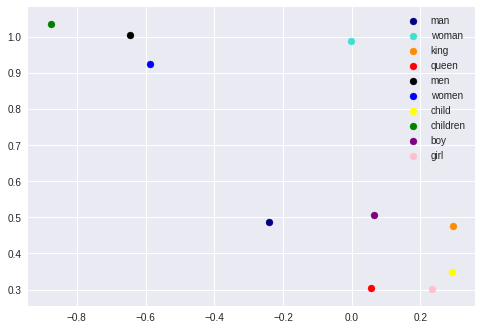

In [0]:
plot_pca(['man', 'woman', 'king', 'queen','men','women','child','children','boy','girl'])

You see in the example above that the plural nouns ('men', 'women', 'children') are concentrated in the upper left corner and that there is distinction between adult people and children ('man' and 'woman' more to the middle, 'boy', 'girl' and 'child' in the lower right corner).

Now try it yourself. Notice that only words that are in the vocabulary will be plotted.

In [0]:
# plot_pca([])

You will notice that not all words display nice clear relationships in embedding space. Usually, for frequent words and relationships the results should be clear enough.

Another way to inspect word embeddings is to look at words that are closest to a specific target word. Closeness in a vector space can be calculated based on the cosine similarity. In the function below, we calculate for a given word the top 10 closest words.

In [0]:
def find_closest_words(word):
  if word not in item_to_id:
    raise IOError('This item is not in the vocabulary')
    
  else:
    id_w = item_to_id[word]
    emb_w = emb_matrix[id_w]
    norm_emb_w = emb_w / np.linalg.norm(emb_w)
    
    top_10 = {}
    
    # iterate over all words
    for idx in range(emb_matrix.shape[0]):
      # ignore the word itself
      if idx != id_w:
        
        norm_curr_w = emb_matrix[idx] / np.linalg.norm(emb_matrix[idx])
        
        # cosine similarity = dot product of normalized vectors
        cos_sim = np.dot(norm_emb_w, norm_curr_w)
        
        # keep list of top 10 largest cos similarities
        if len(top_10) >= 10:
          for sim in top_10.iterkeys():
            if cos_sim > sim:
              
              del top_10[sim]
              top_10[cos_sim] = id_to_item[idx]
              break
        
        else:
          top_10[cos_sim] = id_to_item[idx]
          
        
    print('Words with largest cosine similarity w.r.t. {0}'.format(word))
    # sort the top 10 
    for sim in sorted(top_10, key=float, reverse=True):
      print('{0} ({1})'.format(top_10[sim], sim))
    print()
      
     
    
 
    
    

The function above can be called as follows:

In [0]:
find_closest_words('man')
find_closest_words('help')

Words with largest cosine similarity w.r.t. man
artist (0.415580644469)
driver (0.376201423505)
investigator (0.344296556218)
actor (0.33444143473)
collins (0.315727783487)
albert (0.311157892865)
downey (0.308659725171)
supervisor (0.295695289621)
outsider (0.280173457463)
barry (0.273468881175)

Words with largest cosine similarity w.r.t. help
helped (0.433193394718)
helps (0.318657859787)
laws (0.318054053432)
sample (0.301497871059)
staffs (0.296166505538)
pesetas (0.293924983381)
statutes (0.280734101887)
drinks (0.273401642214)
let (0.271040899948)
encouraged (0.262834127029)



You will notice that the closest words to 'man' mostly correspond to specific types of men (professions, proper names) and that the two words closest to 'help' are conjugation of 'help'. Thus, we see that both semantic and syntactic relationships are present in the embedding space. Notice that we did not optimize our embedding space to contain such relationships! This is merely a by-product of training a neural language model. 

Now try it for yourself. It is best to choose frequent words, because these will have better estimates. An error will be thrown if the word is not in the vocabulary. 

In [0]:
# find_closest_words('')

Notice that not all words will have sensible nearest neighbours, because the model is trained on a relatively small dataset, not all words will have large enough frequency and the model is not optimized to encode these relationships.

## Testing

Before going into the details of training a neural language model, we will first show how you can use a trained model. The output of the neural network is given to a **softmax** function, which converts the output values (also called logits) to a values between 0 and 1. The sum of those values is 1, and thus the output of the softmax function can be treated as a probability distribution. 

We can then find the probability of a specific word  following the current input word by looking up its probability in the output vector of the softmax function. To find the most probable word, we look for the maximum probability. In practice, we usually work with **log probabilities**, because if we are computing the probability of a sequence of words, the multiplication of all probabilities easily becomes very small. Converting the probabilities to the log domain and summing them instead of multiplying alleviates this problem. The log probability of a sentence is then sum of the log probabilities of every word in the sentence, given their context.

Let's first train a network:

In [0]:
# first make sure that we start training the model from scratch, by removing the models/ directory
!rm -rf baseline

# train the model
run_lm.run_lm(name='baseline', train_ids=train_ids, valid_ids=valid_ids, test_ids=test_ids)

Instructions for updating:
Please switch to tf.train.MonitoredTrainingSession
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Starting standard services.
INFO:tensorflow:Saving checkpoint to path baseline/model.ckpt
INFO:tensorflow:Starting queue runners.
Epoch 1
Train perplexity: 1447.97646968
Validation perplexity: 993.289069086
Epoch 2
Train perplexity: 699.401461693
Validation perplexity: 1399.20045655
Epoch 3
Train perplexity: 568.595862118
Validation perplexity: 878.540353237
Epoch 4
Train perplexity: 474.298501446
Validation perplexity: 852.888882637
Epoch 5
Train perplexity: 410.171997889
Validation perplexity: 889.620133804
('Saved the model to ', 'baseline/rnn.ckpt')
Test perplexity: 748.445416523


During training, not the log probabilities are printed but the **perplexity** of the model. Perplexity is commonly used to measure the quality of a language model, and corresponds to $$e^{\frac{1}{N}~ln~P(x_1~\ldots~x_N)}$$ You see that it is closely related to the log probability. The lower the perplexity, the better. Notice that in the example above the perplexities are quite high because we are training a small model on a small dataset.

To test the model we define a function that print the log probability of a sentence. The sentence is converted to indices and then given to the model:

In [0]:
def get_log_prob(test_sent):
  
  # convert words to indices
  test_idx = []
  for w in test_sent.split(' '):
    if w not in item_to_id:
      raise IOError("{0} is not part of the vocabulary".format(w))
    else:
      test_idx.append(item_to_id[w])

  # feed sentence to the model
  run_lm.run_lm(name='baseline',
                test_ids=test_idx,
                test_log_prob=True)

To get the log probability of a specific sentence, use the following commands:

In [0]:
get_log_prob(test_sent='this is a test <eos>')
get_log_prob(test_sent='test a a a <eos>')

INFO:tensorflow:Restoring parameters from baseline/rnn.ckpt
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Starting standard services.
INFO:tensorflow:Saving checkpoint to path baseline/model.ckpt
INFO:tensorflow:Starting queue runners.
Log probability: -19.4600217342
INFO:tensorflow:Restoring parameters from baseline/model.ckpt
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Starting standard services.
INFO:tensorflow:Saving checkpoint to path baseline/model.ckpt
INFO:tensorflow:Starting queue runners.
Log probability: -23.6687660217


You should see that the log probability of 'test a a a' is lower than 'this is a test', which makes sense. You can test your own sentences here:

In [0]:
# get_log_prob('your own test sentence')

## Training networks

Training neural networks requires a lot of hyperparameter tuning. The hyperparameters of a neural network are for example the type of cell, its size, the method that is used for updating its parameters (also called 'optimizer' ), the type and strength of regularization, ... . All these hyperparameters have to be chosen before the network can built, trained and tested, and they all have to some extent an influence on the  performance of the model.

The default arguments for our network are the following:


* cell: 'LSTM'
* optimizer: 'Adam'
* lr: 0.01
* embedding_size: 64
* hidden_size: 128
* dropout_rate: 0.5

We will explain each of these arguments in the following sections.



### Type of cell

Recurrent neural networks are neural networks that take as input a combination of the standard input and the hidden state of the previous time step. The simples form of recurrent neural network, often called **vanilla recurrent neural network**, looks like this (picture taken from the Chris Olah's [blog post](http://colah.github.io/posts/2015-08-Understanding-LSTMs/)):

![alt text](http://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-SimpleRNN.png)

The green blocks in the picture represent the neural network. You see that the input to the neural network is the current input word $\mathbf{x}_t$ (this is the word embedding as discussed before) and the state of the previous time step $\mathbf{h}_{t-1}$. The network multiplies both inputs with weights and applies a non-linearity, in this case $\tanh$. 

The network that we trained before is not a vanilla recurrent neural network, but a **long short-term memory (LSTM)** network, which is a more powerful variant. If you're interested in knowing how the LSTM works, the blog post mentioned above is a great introduction.

For comparison, let's now train a simple RNN instead of an LSTM:

In [0]:
run_lm.run_lm(name='RNN', cell='RNN', train_ids=train_ids, valid_ids=valid_ids, test_ids=test_ids)

Instructions for updating:
This class is equivalent as tf.keras.layers.SimpleRNNCell, and will be replaced by that in Tensorflow 2.0.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Starting standard services.
INFO:tensorflow:Starting queue runners.
Epoch 1
INFO:tensorflow:Saving checkpoint to path RNN/model.ckpt
Train perplexity: 1609.8100344
Validation perplexity: 1709.94407175
Epoch 2
Train perplexity: 1220.17028663
Validation perplexity: 1769.71985333
Epoch 3
Train perplexity: 1991.58008276
Validation perplexity: 1407.66574336
Epoch 4
Train perplexity: 1912.28721208
Validation perplexity: 1682.29639204
Epoch 5
Train perplexity: 1114.66197652
Validation perplexity: 6183.51155314
('Saved the model to ', 'RNN/rnn.ckpt')
Test perplexity: 1824.66687647


Notice that the simple RNN performs much worse than the LSTM (the perplexities are much higher).

### Optimizer

Another important hyperparameter for neural networks is the type of optimizer. Training a neural network implies that you give an input to the network, calculate the output and the difference with the expected output, which is equal to the **error** or **loss**. To update the parameters based on the error, the **gradient** of the loss with respect to the parameters is calculated. The gradient tells you in which direction you need to move to maximize the loss. In our case, we want to minimize the loss so we will move in the opposite direction (negative gradient). The optimizer then decides how this gradient is used to change the parameters. 

The simplest option is to subtract (a scaled version of) the gradient from the parameters. This optimizer is called **stochastic gradient descent**. In the experiments above, we used another, more complicated, optimizer called **Adam**.

Let's now train a network with stochastic gradient descent instead of Adam:

In [0]:
run_lm.run_lm(name='SGD', optimizer='SGD', train_ids=train_ids, valid_ids=valid_ids, test_ids=test_ids)

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Starting standard services.
INFO:tensorflow:Starting queue runners.
Epoch 1INFO:tensorflow:Saving checkpoint to path SGD/model.ckpt

Train perplexity: 9186.59364969
Validation perplexity: 8141.78240986
Epoch 2
Train perplexity: 6065.43037208
Validation perplexity: 4032.29537378
Epoch 3
Train perplexity: 2769.55178482
Validation perplexity: 2008.14325483
Epoch 4
Train perplexity: 1710.71481956
Validation perplexity: 1529.92930378
Epoch 5
Train perplexity: 1358.24520146
Validation perplexity: 1270.82988022
('Saved the model to ', 'SGD/rnn.ckpt')
Test perplexity: 1293.92585833


You see that the perplexities are worse than for our baseline model. 

### Learning rate

Judging from the perplexities above, it seems like the Adam optimizer is the best choice for training our network. However, the interplay between the different hyperparameters of a neural network is complicated, and it is very well possible that a specific optimizer needs a different learning rate. 
Let's try SGD with a learning rate of 1 instead of the default 0.01:

In [0]:
run_lm.run_lm(name='SGD_1', optimizer='SGD', lr=1.0, train_ids=train_ids, valid_ids=valid_ids, test_ids=test_ids)

INFO:tensorflow:Restoring parameters from SGD_1/model.ckpt
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Starting standard services.
INFO:tensorflow:Saving checkpoint to path SGD_1/model.ckpt
INFO:tensorflow:Starting queue runners.
Epoch 1
Train perplexity: 2125.06696489
Validation perplexity: 1476.35489629
Epoch 2
Train perplexity: 1123.91289647
Validation perplexity: 1072.41441349
Epoch 3
Train perplexity: 898.158958219
Validation perplexity: 817.106373992
Epoch 4
Train perplexity: 753.575677324
Validation perplexity: 708.281370471
Epoch 5
Train perplexity: 642.380342671
Validation perplexity: 699.612842301
('Saved the model to ', 'SGD_1/rnn.ckpt')
Test perplexity: 646.475704884


We see that a larger learning rate helps for SGD, and gives even better results than Adam. Maybe using a larger learning rate helps in general? Let's try the same learning rate in combination with Adam:

In [0]:
run_lm.run_lm(name='Adam_1', lr=1.0, train_ids=train_ids, valid_ids=valid_ids, test_ids=test_ids)

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Starting standard services.
INFO:tensorflow:Saving checkpoint to path Adam_1/model.ckpt
INFO:tensorflow:Starting queue runners.
Epoch 1
Train perplexity: 1.6738995113e+35
Validation perplexity: 1.6106968461e+45
Epoch 2
Train perplexity: 9.21123613851e+34
Validation perplexity: 2.40963260498e+32
Epoch 3
Train perplexity: 5.63367315076e+35
Validation perplexity: 2.66634596084e+37
Epoch 4
Train perplexity: 2.08337041868e+37
Validation perplexity: 8.63949167109e+37
Epoch 5
Train perplexity: 3.10557340851e+36
Validation perplexity: 8.68642949398e+35
('Saved the model to ', 'Adam_1/rnn.ckpt')
Test perplexity: 6.2909002862e+35


This gives terrible results, which clearly indicates that it is important to tune the learning rate and the optimizer jointly. For Adam, a smaller learning rate is better. What if we reduce the learning rate further, from 0.01 to 0.001?

In [0]:
run_lm.run_lm(name='Adam_0.001', lr=0.001, train_ids=train_ids, valid_ids=valid_ids, test_ids=test_ids)

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Starting standard services.
INFO:tensorflow:Saving checkpoint to path Adam_0.001/model.ckpt
INFO:tensorflow:Starting queue runners.
Epoch 1
Train perplexity: 3569.66542718
Validation perplexity: 978.966751897
Epoch 2
Train perplexity: 697.015506413
Validation perplexity: 947.301051956
Epoch 3
Train perplexity: 661.234727646
Validation perplexity: 956.275353676
Epoch 4
Train perplexity: 645.161367668
Validation perplexity: 956.699421319
Epoch 5
Train perplexity: 673.492560025
Validation perplexity: 953.859007018
('Saved the model to ', 'Adam_0.001/rnn.ckpt')
Test perplexity: 837.943287268


This is slightly worse than the baseline perplexity. 

### Size of the embedding

Let's now take a look at the influence of the size of the LSTM on its performance. By default, we train a model with embeddings of size 64 and a hidden layer of size 128. Let's see what happens if we reduce the size of the embedding:

In [0]:
run_lm.run_lm(name='emb16', embedding_size=16, train_ids=train_ids, valid_ids=valid_ids, test_ids=test_ids)

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Starting standard services.
INFO:tensorflow:Saving checkpoint to path emb16/model.ckpt
INFO:tensorflow:Starting queue runners.
Epoch 1
Train perplexity: 1452.31607755
Validation perplexity: 980.647685402
Epoch 2
Train perplexity: 706.728881564
Validation perplexity: 1290.7853409
Epoch 3
Train perplexity: 606.009862433
Validation perplexity: 1130.55933214
Epoch 4
Train perplexity: 552.040121515
Validation perplexity: 870.350705537
Epoch 5
Train perplexity: 482.286987845
Validation perplexity: 902.309769022
('Saved the model to ', 'emb16/rnn.ckpt')
Test perplexity: 777.968927924


A smaller embedding size gives slightly worse results.  What about a larger embedding size?

In [0]:
run_lm.run_lm(name='emb128', embedding_size=128, train_ids=train_ids, valid_ids=valid_ids, test_ids=test_ids)

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Starting standard services.
INFO:tensorflow:Saving checkpoint to path emb128/model.ckpt
INFO:tensorflow:Starting queue runners.
Epoch 1
Train perplexity: 1504.28973842
Validation perplexity: 1031.59011262
Epoch 2
Train perplexity: 692.559943784
Validation perplexity: 867.1853053
Epoch 3
Train perplexity: 537.566607546
Validation perplexity: 848.980220534
Epoch 4
Train perplexity: 442.985098957
Validation perplexity: 832.782362787
Epoch 5
Train perplexity: 379.935115053
Validation perplexity: 878.801423174
('Saved the model to ', 'emb128/rnn.ckpt')
Test perplexity: 736.466715072


This should give better results, but notice that the differences are small.

### Size of the hidden layer

We can also change the size of the hidden layer/the number of neurons in the network. In principle you also choose to increase the number of layers, but this is mainly useful for large datasets.

Let's first test a smaller hidden layer:

In [0]:
run_lm.run_lm(name='hidden64', hidden_size=64, train_ids=train_ids, valid_ids=valid_ids, test_ids=test_ids)

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Starting standard services.
INFO:tensorflow:Saving checkpoint to path hidden64/model.ckpt
INFO:tensorflow:Starting queue runners.
Epoch 1
Train perplexity: 1677.70257795
Validation perplexity: 1099.17567984
Epoch 2
Train perplexity: 740.42272477
Validation perplexity: 928.991178583
Epoch 3
Train perplexity: 613.996031245
Validation perplexity: 909.624262789
Epoch 4
Train perplexity: 514.14685331
Validation perplexity: 870.480120328
Epoch 5
Train perplexity: 445.795121091
Validation perplexity: 881.397887168
('Saved the model to ', 'hidden64/rnn.ckpt')
Test perplexity: 749.518940256


We observe almost no difference for a smaller hidden layer. 

In [0]:
run_lm.run_lm(name='hidden256', hidden_size=256, train_ids=train_ids, valid_ids=valid_ids, test_ids=test_ids)

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Starting standard services.
INFO:tensorflow:Starting queue runners.
Epoch 1
INFO:tensorflow:Saving checkpoint to path hidden256/model.ckpt
Train perplexity: 1365.41560209
Validation perplexity: 1013.17449997
Epoch 2
Train perplexity: 631.971166415
Validation perplexity: 2357.3619663
Epoch 3
Train perplexity: 532.601764739
Validation perplexity: 902.201833147
Epoch 4
Train perplexity: 459.805993293
Validation perplexity: 862.397190502
Epoch 5
Train perplexity: 395.757067641
Validation perplexity: 1043.19493401
('Saved the model to ', 'hidden256/rnn.ckpt')
Test perplexity: 736.215451823


A larger hidden layer moderately improves the results, but again the difference is small. Notice that parameters such as the size of the embedding and the size of the hidden layer will have a larger effect for large data sets. To see this, we will now train on the full Penn TreeBank data set by using {train/valid/test}_ids_large:

In [0]:
run_lm.run_lm(name='large', train_ids=train_ids_large, valid_ids=valid_ids_large, test_ids=test_ids_large)

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Starting standard services.
INFO:tensorflow:Saving checkpoint to path large/model.ckpt
INFO:tensorflow:Starting queue runners.
Epoch 1
Train perplexity: 448.133119457
Validation perplexity: 309.512903591
Epoch 2
Train perplexity: 264.139868696
Validation perplexity: 260.352211332
Epoch 3
Train perplexity: 221.642533035
Validation perplexity: 242.831497651
Epoch 4
Train perplexity: 202.418798594
Validation perplexity: 230.736476619
Epoch 5
Train perplexity: 190.955553896
Validation perplexity: 224.564248629
('Saved the model to ', 'large/rnn.ckpt')
Test perplexity: 209.699917701


Let's now train a model with a larger hidden size:

In [0]:
run_lm.run_lm(name='large_hidden256', hidden_size=256, 
              train_ids=train_ids_large, valid_ids=valid_ids_large, test_ids=test_ids_large)

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Starting standard services.
INFO:tensorflow:Starting queue runners.
Epoch 1INFO:tensorflow:Saving checkpoint to path large_hidden256/model.ckpt

Train perplexity: 397.047016231
Validation perplexity: 273.377945013
Epoch 2
Train perplexity: 247.25939606
Validation perplexity: 228.659513446
Epoch 3
Train perplexity: 190.373732934
Validation perplexity: 210.419504074
Epoch 4
Train perplexity: 171.263610246
Validation perplexity: 203.691183703
Epoch 5
Train perplexity: 159.386447743
Validation perplexity: 199.9164812
('Saved the model to ', 'large_hidden256/rnn.ckpt')
Test perplexity: 188.050517488


We see that for the larger data set, increasing the model size gives larger gains.

### Try it yourself

Now try some different values for the hyperparameters that we discussed:

In [0]:
# run_lm.run_lm(name='', train_ids=train_ids_large, valid_ids=valid_ids_large, test_ids=test_ids_large)

The hyperparameters that we discussed here are only a small subset, there exist many more that can have an influence on the performance of the neural network. Another important class of hyperparameters is related to **regularization**. Since neural networks contain many parameters, they can easily start **overfitting**, which means that the network starts memorizing the training set and cannot generalize well to new data sets anymore. Two important methods are dropout (setting a proportion of the neurons to 0 during training) and early stopping (stop training if the performance on the validation set decreases), but there exist many more.